# Transfer Learning for Classifying Politicians 

Since the politicians dataset is rather small, we would like to use a pre-trained network for our classification. However, the question asked is weather to use **all** the layers or just **part** of them as a strating point for out task. Another question raised here is weather to keep them **fix** or **fine-tune** them.

In this assignment we will dive into these questions (does is sound familiar to you? this is what the paper from research seminar is about).




In [2]:
%matplotlib inline


In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()   # interactive mode
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

### Loading the Data


In [4]:
# Create a folder for our data
# The ! prefix runs this as a shell command
!mkdir data
!mkdir data/israeli_politicians

In [5]:
# Download our dataset and extract it
import requests
from zipfile import ZipFile

url = 'https://github.com/omriallouche/ydata_deep_learning_2021/blob/main/data/israeli_politicians.zip?raw=true'
r = requests.get(url, allow_redirects=True)
open('./data/israeli_politicians.zip', 'wb').write(r.content)

with ZipFile('./data/israeli_politicians.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(path='./data/israeli_politicians/')

### Datasets Loader


In [6]:
# Define transformations that resize the images to 256x256, and normalize them. 
# The means and standard deviations of each channel are the values used for normalization in ImageNet
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
}

In [7]:
data_dir = r'./data/israeli_politicians/'

# Create a dictionary of train and val datasets from images in folders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=16,
                                             shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=16,
                                          shuffle=False, num_workers=4)
  }

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print('dataset_sizes: ', dataset_sizes)

class_names = image_datasets['train'].classes
print('class_names:', class_names)

dataset_sizes:  {'train': 929, 'val': 234}
class_names: ['ayelet_shaked', 'benjamin_netanyahu', 'benny_gantz', 'danny_danon', 'gideon_saar', 'kostya_kilimnik', 'naftali_bennett', 'ofir_akunis', 'yair_lapid']


In [8]:
# Check for the availability of a GPU, and use CPU otherwise
# If you are using Google Colab, be sure to change your runtime environment to GPU first.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations.



In [9]:
# A helper function to show an image from a tensor. We need to restore it to the original dynamic range before normalization
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(means)
    std = np.array(stds)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [10]:
# Get a batch of training data - the data loader is a generator
inputs, classes = next(iter(dataloaders['train']))

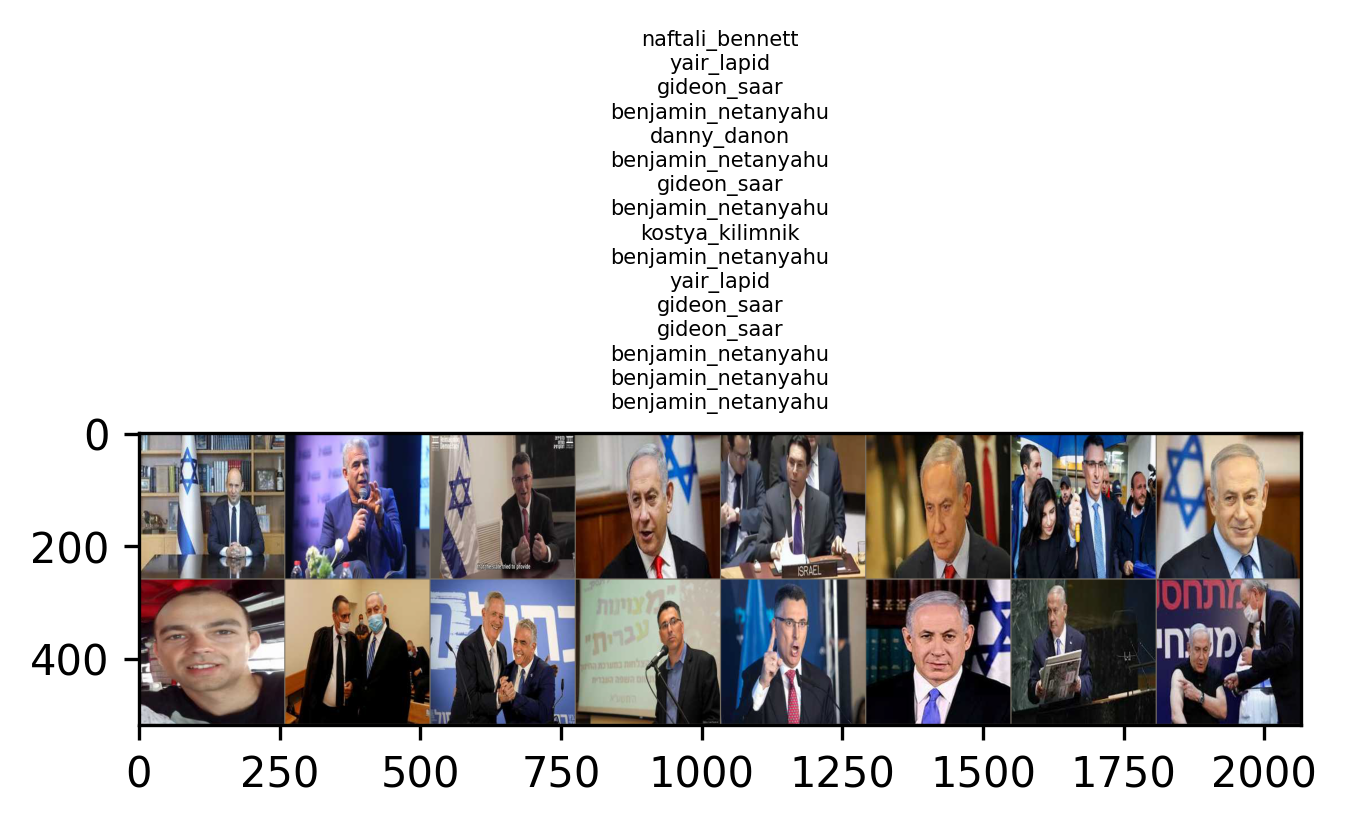

In [11]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)

imshow(out, title='\n'.join([class_names[x] for x in classes]))

In [12]:
import copy
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            dict_res[phase][0,epoch]=epoch_loss
            dict_res[phase][1,epoch]=epoch_acc

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, dict_res,best_acc


## Using a pretrained model - finetune all layers

This was the first task of the course, loading a model pretrained on ImageNet, and use it for our task.  
We will use the VGG16 network, that won the ImageNet Challenge in 2016 and change the last linear layer to 9 output features:

In [13]:
# We load a pretrain model with its weights. Alternatively, one might want to only load the model architecture.
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=9)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 167MB/s]


Let's review our change in the model:

In [14]:

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
!pip install torchsummary 
from torchsummary import summary
summary(model.to(device), (3, 256, 256))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
    

In [16]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
num_epochs = 10

In [17]:
model,dict_res,_ = train_model(model.to('cuda'), 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 1.7795 Acc: 0.3606
val Loss: 1.4394 Acc: 0.5171

Epoch 1/9
----------
train Loss: 1.1175 Acc: 0.6179
val Loss: 1.0174 Acc: 0.6453

Epoch 2/9
----------
train Loss: 0.5884 Acc: 0.7976
val Loss: 1.0975 Acc: 0.6752

Epoch 3/9
----------
train Loss: 0.3745 Acc: 0.8719
val Loss: 0.7790 Acc: 0.7778

Epoch 4/9
----------
train Loss: 0.1947 Acc: 0.9322
val Loss: 0.8303 Acc: 0.7692

Epoch 5/9
----------
train Loss: 0.1059 Acc: 0.9656
val Loss: 0.8598 Acc: 0.7821

Epoch 6/9
----------
train Loss: 0.0789 Acc: 0.9806
val Loss: 0.7242 Acc: 0.8077

Epoch 7/9
----------
train Loss: 0.0312 Acc: 0.9946
val Loss: 0.7230 Acc: 0.8333

Epoch 8/9
----------
train Loss: 0.0264 Acc: 0.9935
val Loss: 0.7205 Acc: 0.8248

Epoch 9/9
----------
train Loss: 0.0182 Acc: 0.9968
val Loss: 0.7405 Acc: 0.8162

Training complete in 3m 18s
Best val Acc: 0.833333


In [18]:
def plot_convergence(dict_res, num_epochs):
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  types=['Loss', 'Accuracy']
  plt.subplot(1,2,1); plt.plot(dict_res['train'][0]); plt.plot(dict_res['val'][0]); plt.title('Loss'); plt.legend(['train','val'])
  plt.subplot(1,2,2); plt.plot(dict_res['train'][1]); plt.plot(dict_res['val'][1]); plt.title('Accuracy'); plt.legend(['train','val'])


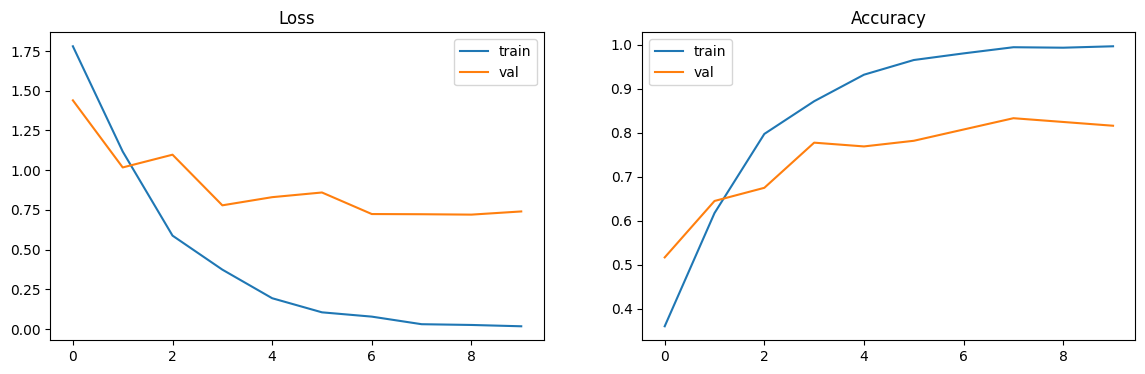

In [19]:
plot_convergence(dict_res,num_epochs ); plt.show()
#0.81

## (1) Using a pretrained model - fixed NN feature (30 points)
Use pre-trained VGG16 model with fixed weights of all layers (up to the last one, of course).

**Do not forget to load the model again, otherwise the training will start from where the last training stopped**

Epoch 0/9
----------
train Loss: 1.8802 Acc: 0.3445
val Loss: 1.6161 Acc: 0.4017

Epoch 1/9
----------
train Loss: 1.5404 Acc: 0.4650
val Loss: 1.4630 Acc: 0.4744

Epoch 2/9
----------
train Loss: 1.3572 Acc: 0.5135
val Loss: 1.4259 Acc: 0.5085

Epoch 3/9
----------
train Loss: 1.2852 Acc: 0.5414
val Loss: 1.4047 Acc: 0.5085

Epoch 4/9
----------
train Loss: 1.2120 Acc: 0.5759
val Loss: 1.4752 Acc: 0.4872

Epoch 5/9
----------
train Loss: 1.2194 Acc: 0.5802
val Loss: 1.3180 Acc: 0.5769

Epoch 6/9
----------
train Loss: 1.1123 Acc: 0.5974
val Loss: 1.3190 Acc: 0.5598

Epoch 7/9
----------
train Loss: 1.1026 Acc: 0.6157
val Loss: 1.2623 Acc: 0.5855

Epoch 8/9
----------
train Loss: 1.0201 Acc: 0.6792
val Loss: 1.2659 Acc: 0.5897

Epoch 9/9
----------
train Loss: 1.0189 Acc: 0.6469
val Loss: 1.2792 Acc: 0.5812

Training complete in 1m 37s
Best val Acc: 0.589744


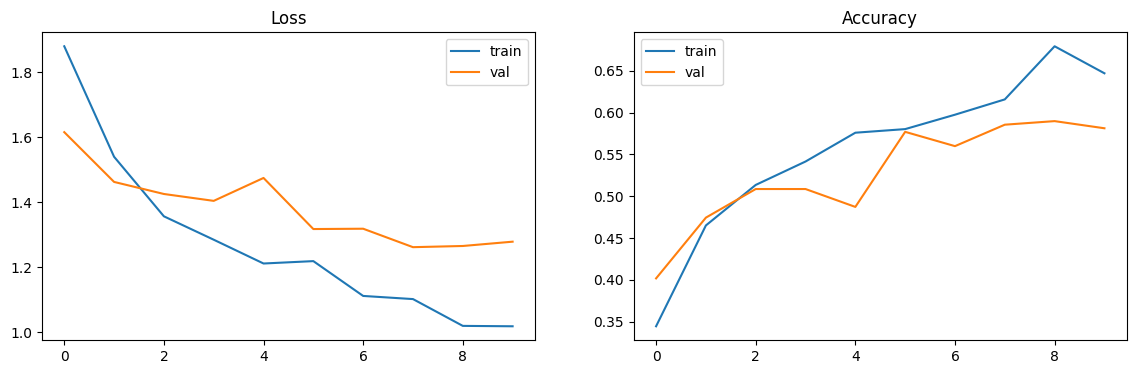

In [20]:
# Best val Acc: 0.581197
model = models.vgg16(pretrained=True)

# freeze all layers except for the last layer
for param in model.parameters():
    param.requires_grad = False

# replace the last layer with a new fully connected layer
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, 9)

# set the last layer to be trainable
for param in model.classifier[-1].parameters():
    param.requires_grad = True

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
num_epochs = 10
model,dict_res,_ = train_model(model.to('cuda'), 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)
plot_convergence(dict_res,num_epochs ); plt.show()

## (2) Using a pretrained model - fixed some feature, tine-tune the rest (30 points)

Epoch 0/9
----------
train Loss: 1.8390 Acc: 0.3563
val Loss: 1.4216 Acc: 0.5427

Epoch 1/9
----------
train Loss: 1.0442 Acc: 0.6459
val Loss: 0.9060 Acc: 0.6838

Epoch 2/9
----------
train Loss: 0.5869 Acc: 0.7976
val Loss: 1.0474 Acc: 0.6624

Epoch 3/9
----------
train Loss: 0.2891 Acc: 0.9031
val Loss: 0.8633 Acc: 0.7607

Epoch 4/9
----------
train Loss: 0.2002 Acc: 0.9300
val Loss: 0.8291 Acc: 0.7479

Epoch 5/9
----------
train Loss: 0.1057 Acc: 0.9709
val Loss: 0.7158 Acc: 0.8034

Epoch 6/9
----------
train Loss: 0.0467 Acc: 0.9839
val Loss: 0.8353 Acc: 0.8077

Epoch 7/9
----------
train Loss: 0.0262 Acc: 0.9925
val Loss: 0.7070 Acc: 0.8077

Epoch 8/9
----------
train Loss: 0.0135 Acc: 0.9957
val Loss: 0.6968 Acc: 0.8077

Epoch 9/9
----------
train Loss: 0.0132 Acc: 0.9957
val Loss: 0.7017 Acc: 0.8162

Training complete in 2m 34s
Best val Acc: 0.816239


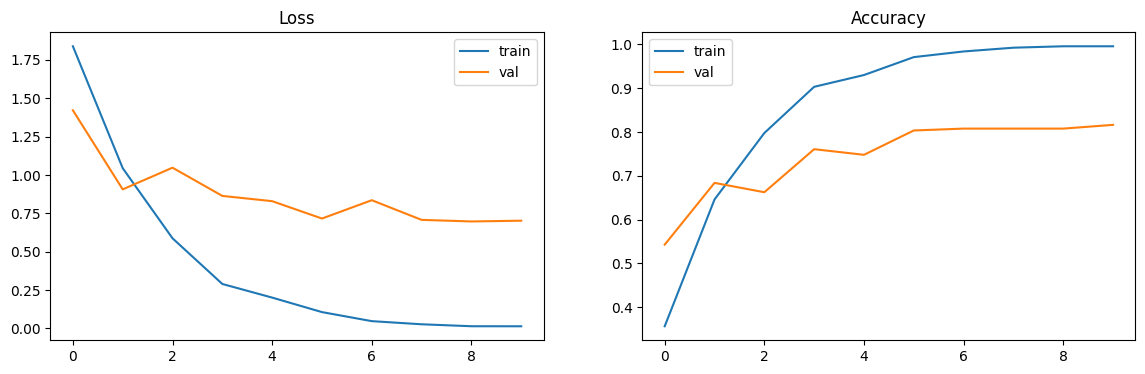

In [21]:
""" best n layers 7
acc 0.8376"""
model = models.vgg16(pretrained=True)
# Replace the output neurons to 9
num_features = model.classifier[6].in_features

model.classifier[6] = nn.Linear(num_features, 9)

# Freeze the specified number of layers
for idx, layer in enumerate(model.features):
    if idx < 7:
        for param in layer.parameters():
            param.requires_grad = False

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
num_epochs = 10
model,dict_res,acc = train_model(model.to('cuda'), 
                    dataloaders,
                      criterion, 
                      optimizer_ft, 
                      exp_lr_scheduler,
                        num_epochs=num_epochs)
plot_convergence(dict_res,num_epochs ); plt.show()

Use pre-trained VGG16 model with fixed weights of **only part of the layers**. **Fine-tune** the rest of the layers. You should try different amount of layers as you wish. Try to get your best results.

## (3) Using a pretrained model - fixed some feature, from scrach the rest (30 points)

Use pre-trained VGG16 model with fixed weights of **only part of the layers**. **Initialize randomely** the rest of the layers. You should try different amount of layers as you wish. Try to get your best results.

Epoch 0/9
----------
train Loss: 2.0848 Acc: 0.2347
val Loss: 1.9979 Acc: 0.2479

Epoch 1/9
----------
train Loss: 2.0470 Acc: 0.2616
val Loss: 1.9278 Acc: 0.3333

Epoch 2/9
----------
train Loss: 1.8620 Acc: 0.3251
val Loss: 1.8102 Acc: 0.3333

Epoch 3/9
----------
train Loss: 1.8008 Acc: 0.3423
val Loss: 1.7554 Acc: 0.3846

Epoch 4/9
----------
train Loss: 1.7344 Acc: 0.3541
val Loss: 1.6431 Acc: 0.3718

Epoch 5/9
----------
train Loss: 1.6843 Acc: 0.3714
val Loss: 1.5741 Acc: 0.4487

Epoch 6/9
----------
train Loss: 1.5585 Acc: 0.4198
val Loss: 1.6792 Acc: 0.4103

Epoch 7/9
----------
train Loss: 1.4140 Acc: 0.4855
val Loss: 1.4380 Acc: 0.4573

Epoch 8/9
----------
train Loss: 1.3317 Acc: 0.4919
val Loss: 1.4007 Acc: 0.4829

Epoch 9/9
----------
train Loss: 1.2632 Acc: 0.5242
val Loss: 1.3941 Acc: 0.4658

Training complete in 1m 40s
Best val Acc: 0.482906


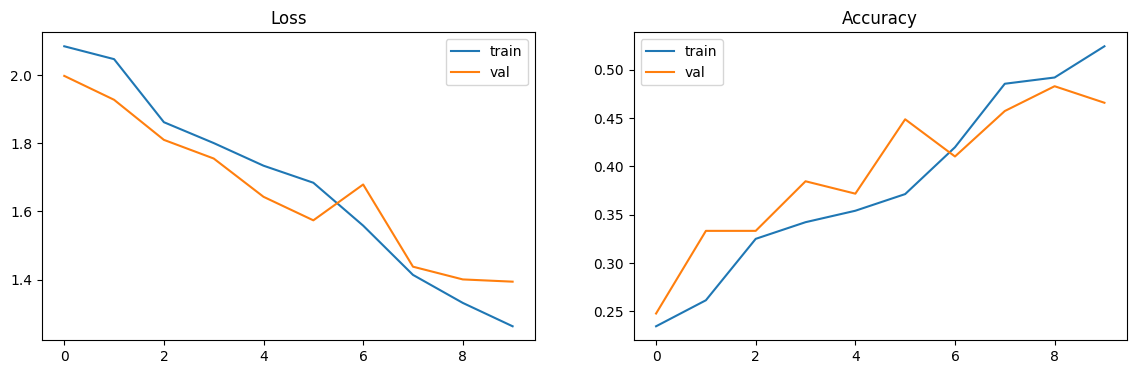

In [22]:
"""best n layers : 28
acc 0.4786"""

def init_weights(layer):
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight)
        if layer.bias is not None:
            nn.init.constant_(layer.bias, 0)


model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(num_features, 9)

# Freeze the specified number of layers
for idx, layer in enumerate(model.features):
    if idx < 28:
        for param in layer.parameters():
            param.requires_grad = False
    else:
      layer.apply(init_weights)

# Print the model summary for this iteration
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
num_epochs = 10
model,dict_res,acc = train_model(model.to('cuda'), 
                    dataloaders,
                      criterion, 
                      optimizer_ft, 
                      exp_lr_scheduler,
                        num_epochs=num_epochs)

plot_convergence(dict_res,num_epochs)
plt.show()

## (4) Using a model - only architecture (from scrach) (10 points)

In this part we will train the model from scrach. Means that we do not use a pre-trained weights at all, only "steal" the architecture of VGG16.

Epoch 0/9
----------
train Loss: 2.1050 Acc: 0.2519
val Loss: 2.0521 Acc: 0.2479

Epoch 1/9
----------
train Loss: 2.0678 Acc: 0.2551
val Loss: 2.0613 Acc: 0.2479

Epoch 2/9
----------
train Loss: 2.0533 Acc: 0.2551
val Loss: 2.0510 Acc: 0.2479

Epoch 3/9
----------
train Loss: 2.0487 Acc: 0.2508
val Loss: 2.0414 Acc: 0.2479

Epoch 4/9
----------
train Loss: 2.0376 Acc: 0.2540
val Loss: 2.0500 Acc: 0.2479

Epoch 5/9
----------
train Loss: 2.0311 Acc: 0.2540
val Loss: 2.0314 Acc: 0.2436

Epoch 6/9
----------
train Loss: 2.0132 Acc: 0.2626
val Loss: 2.0304 Acc: 0.2735

Epoch 7/9
----------
train Loss: 1.9874 Acc: 0.2691
val Loss: 2.0135 Acc: 0.2479

Epoch 8/9
----------
train Loss: 1.9737 Acc: 0.2648
val Loss: 2.0060 Acc: 0.2607

Epoch 9/9
----------
train Loss: 1.9740 Acc: 0.2626
val Loss: 2.0031 Acc: 0.2735

Training complete in 3m 19s
Best val Acc: 0.273504


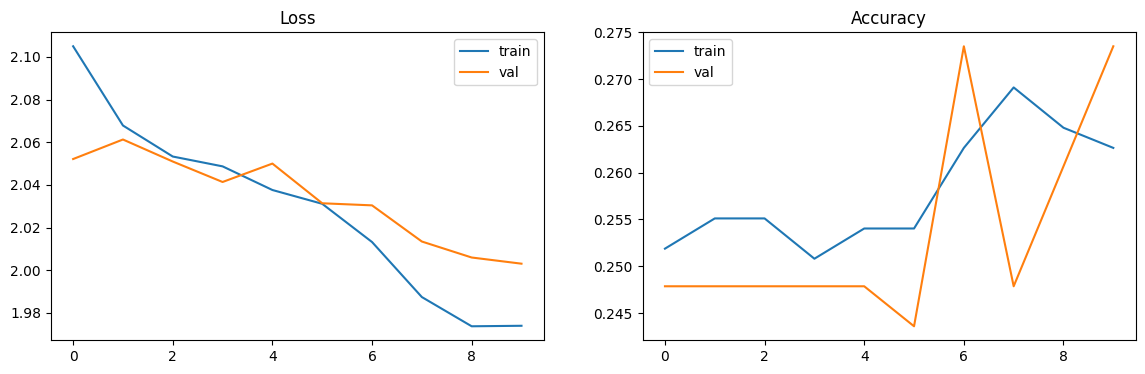

In [23]:
# Best val Acc: 0.273504


model = models.vgg16(pretrained=False)
# Replace the output neurons to 9
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 9)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
num_epochs = 10
model,dict_res,acc = train_model(model.to('cuda'), 
                    dataloaders,
                      criterion, 
                      optimizer_ft, 
                      exp_lr_scheduler,
                        num_epochs=num_epochs)
plot_convergence(dict_res,num_epochs )
plt.show()